https://pubmed.ncbi.nlm.nih.gov/10676951/

https://medium.com/leukemiaairesearch/clustering-techniques-with-gene-expression-data-4b35a04f87d5


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.stats import zscore
import re

In [2]:
data = pd.read_csv("../../cancer_data/OmicsExpressionProteinCodingGenesTPMLogp1.csv", index_col = 0)  
data.columns = [re.match(r'([^\s]+)', col).group(1) for col in data.columns]

In [3]:
ERN_genes_df = pd.read_excel('../../ERN_genes_tables/ERN_genes.xlsx')
ERN_genes = ERN_genes_df['Gene']

In [15]:
ERN_data = data[ERN_genes]

In [4]:
annotation = pd.read_csv("../../R_scripts/depmap_cell_lines_annotation.csv")
annotation_tissues = annotation.set_index('Unnamed: 0')['OncotreeLineage'].to_dict()
annotation_names = annotation.set_index('Unnamed: 0')['StrippedCellLineName'].to_dict()
annotation_cancer = annotation.set_index('Unnamed: 0')['OncotreePrimaryDisease'].to_dict()

data['OncotreeLineage'] = data.index.map(annotation_tissues)
tissue = data.pop("OncotreeLineage")

data['OncotreePrimaryDisease'] = data.index.map(annotation_cancer)
disease = data.pop("OncotreePrimaryDisease")


In [5]:
data.shape

(1450, 19193)

In [6]:
#disease types
print(annotation.OncotreePrimaryDisease.value_counts())

OncotreePrimaryDisease
Non-Small Cell Lung Cancer              163
Non-Cancerous                           132
Diffuse Glioma                          132
Mature B-Cell Neoplasms                 126
Melanoma                                119
                                       ... 
Mixed Cervical Carcinoma                  1
Pancreatic Neuroendocrine Tumor           1
Poorly Differentiated Thyroid Cancer      1
Myelodysplastic Syndromes                 1
Giant Cell Tumor of Bone                  1
Name: count, Length: 93, dtype: int64


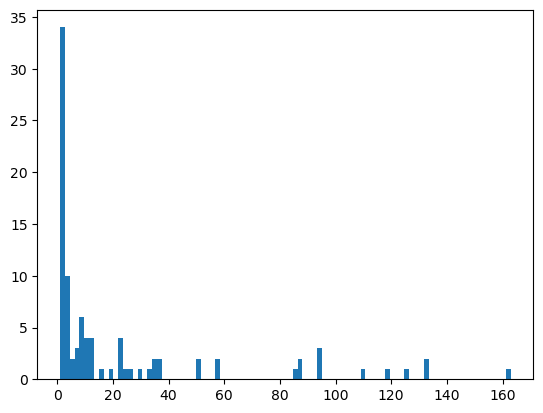

In [7]:
plt.hist(annotation.OncotreePrimaryDisease.value_counts(), bins =annotation.OncotreePrimaryDisease.value_counts().shape[0] )
plt.show()

In [8]:
#tissue types
print(annotation.OncotreeLineage.value_counts())
annotation.OncotreeLineage.value_counts().shape

OncotreeLineage
Lung                         254
Lymphoid                     226
CNS/Brain                    164
Esophagus/Stomach            139
Skin                         132
Breast                       110
Pancreas                      98
Bowel                         97
Head and Neck                 92
Ovary/Fallopian Tube          91
Bone                          84
Myeloid                       83
Kidney                        78
Soft Tissue                   76
Peripheral Nervous System     59
Biliary Tract                 45
Uterus                        42
Fibroblast                    41
Bladder/Urinary Tract         39
Normal                        39
Pleura                        36
Liver                         29
Cervix                        25
Thyroid                       25
Eye                           21
Prostate                      17
Testis                        10
Vulva/Vagina                   5
Muscle                         5
Ampulla of Vater           

(34,)

In [10]:
#annotation[["OncotreeLineage", "OncotreePrimaryDisease"]].drop_duplicates().head(60)

## Normalization 

On this step I can additionally filter out the genes with low variance across cell lines. 

The normalization type is z-score (either this https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html, or this https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html)

#for now I won't drop any genes but for the future it can be done by this command 

data = data.drop(data.var()[(data.var() < 0.1)].index, axis=1) 

In [17]:
from scipy.stats import zscore
data_norm = data.apply(zscore)
ERN_data_norm = ERN_data.apply(zscore)

## PCA

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
X = pca.fit(data_norm).transform(data_norm)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(disease)

y_lan = le.transform(disease)
pca_df = pd.DataFrame()


In [13]:
pca_df.index = data_norm.index
pca_df["PCA1"] = X[:, 0]
pca_df["PCA2"] = X[:, 1]
pca_df["Disease"] = disease
pca_df["label"] = y_lan

In [14]:
pca_df

PCA1       PCA2  \
ACH-001113 -27.041494 -14.946241   
ACH-001289 -39.986691  -4.467209   
ACH-001339  15.116665 -24.669193   
ACH-001538  33.187437 -17.200498   
ACH-000242  -1.344783  -1.635933   
...               ...        ...   
ACH-000285 -55.183378  82.369532   
ACH-002669  45.096303 -10.162714   
ACH-001858  20.963263 -44.605504   
ACH-001997  26.703177 -20.835430   
ACH-000052 -61.310792   9.854036   

                                                    Disease  label  
ACH-001113                       Non-Small Cell Lung Cancer     51  
ACH-001289                                  Embryonal Tumor     16  
ACH-001339                                         Melanoma     39  
ACH-001538  Intraductal Papillary Neoplasm of the Bile Duct     31  
ACH-000242                     Bladder Urothelial Carcinoma      7  
...                                                     ...    ...  
ACH-000285                          Mature B-Cell Neoplasms     36  
ACH-002669                        Colorectal Adenocarcinoma     13  
ACH-001858  Intraductal Papillary Neoplasm of the Bile Duct     31  
ACH-001997  Intraductal Papillary Neoplasm of the Bile Duct     31  
ACH-000052                                    Ewing Sarcoma     21  

[1450 rows x 4 columns]

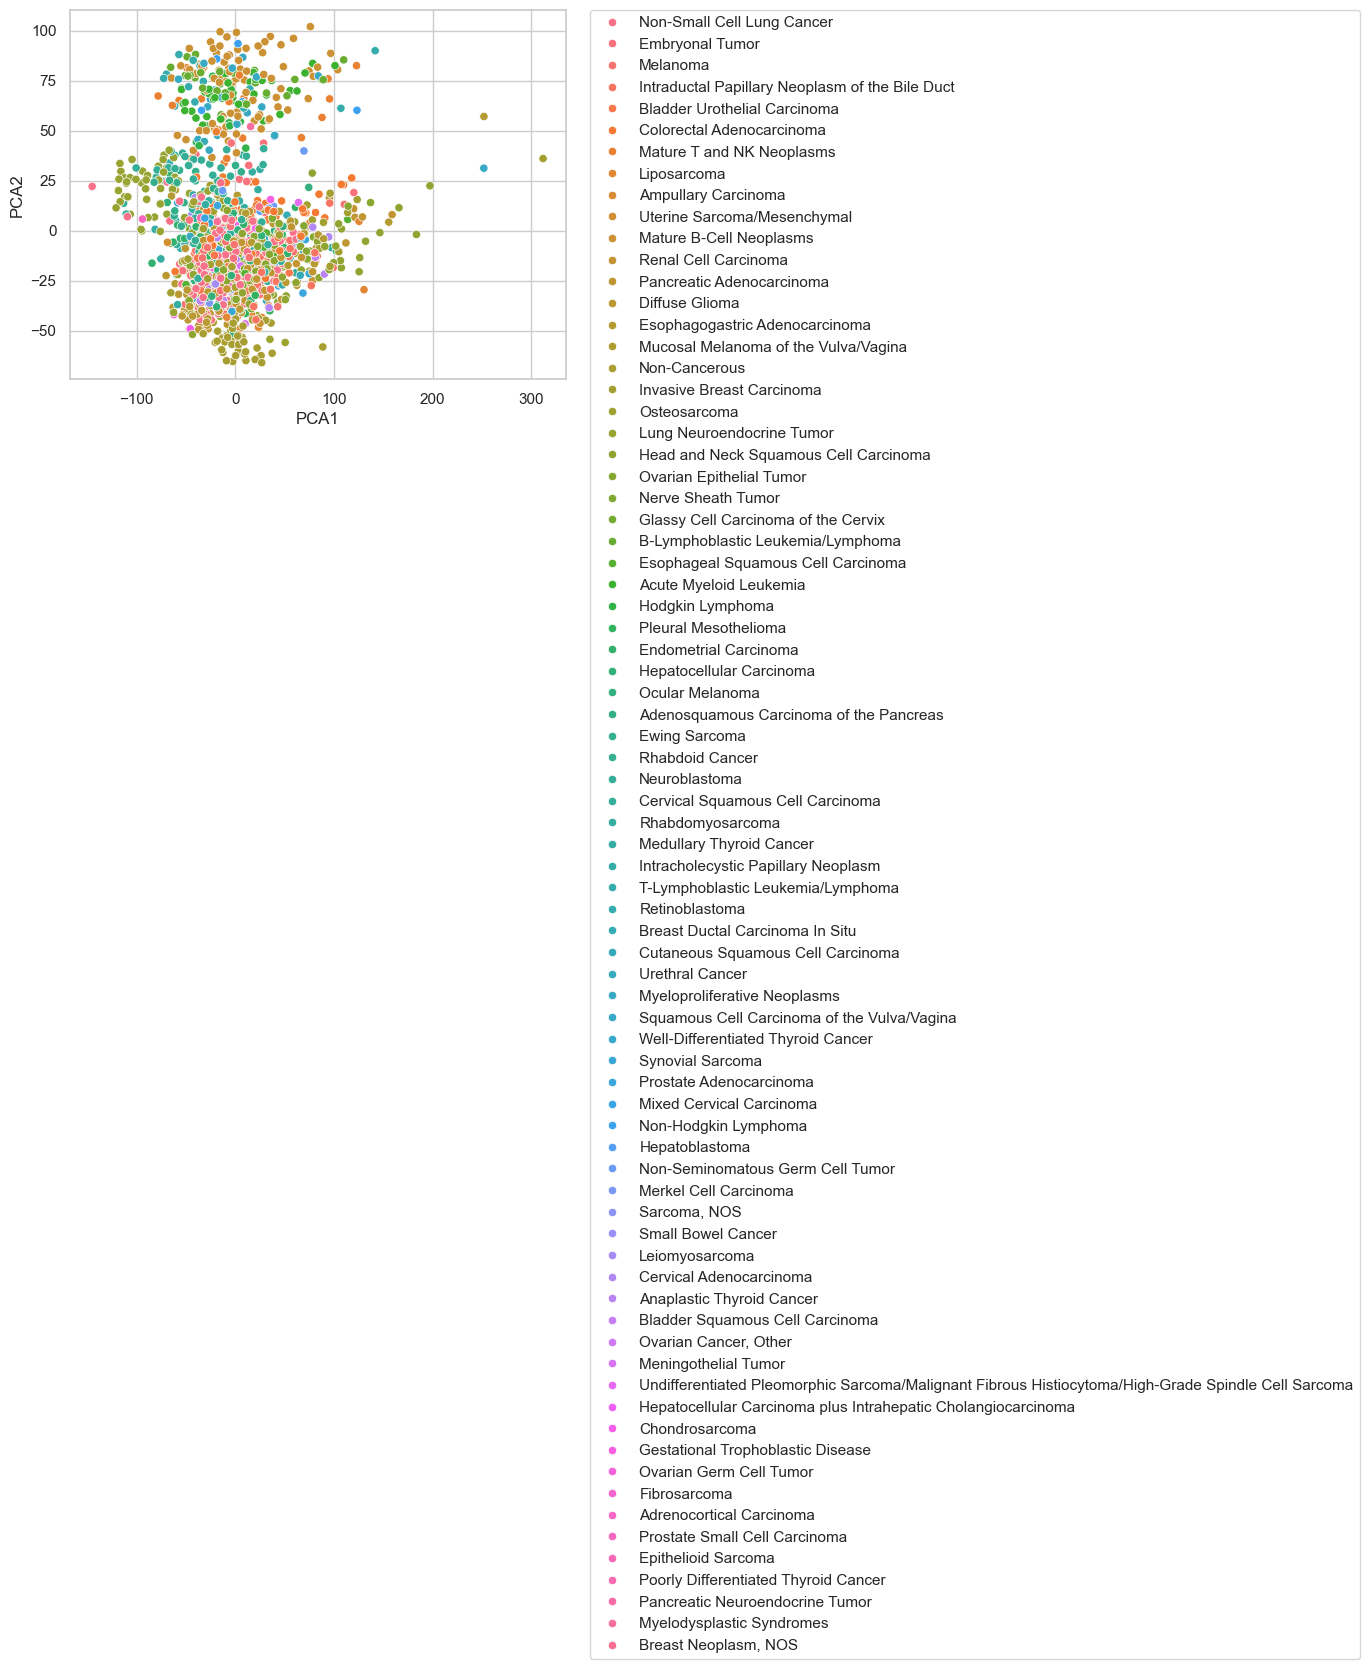

In [15]:
sns.set(style="whitegrid", palette="muted")
#sns.set_theme(style="whitegrid")
ax = sns.scatterplot(x="PCA1", y="PCA2", hue="Disease", data=pca_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig("..._PCA.pdf", dpi = 300)
#plt.savefig("...")
#pca_df.to_csv("...")

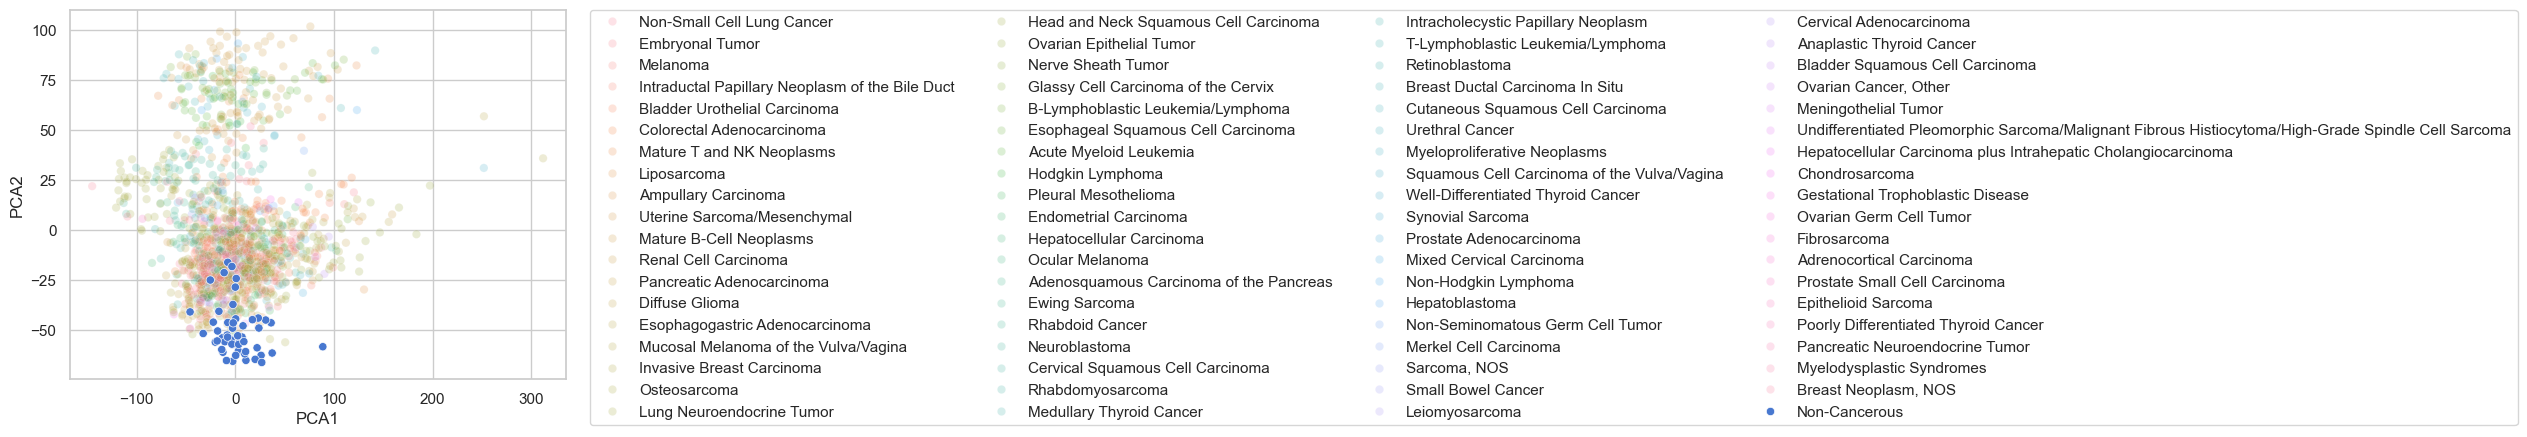

In [28]:
sns.set(style="whitegrid", palette="muted")

# Filter the DataFrame for "Non-cancerous" and other diseases
non_cancerous = pca_df[pca_df['Disease'] == 'Non-Cancerous']
other_diseases = pca_df[pca_df['Disease'] != 'Non-Cancerous']

# First plot the other diseases with higher transparency
ax = sns.scatterplot(x="PCA1", y="PCA2", hue="Disease", data=other_diseases, alpha=0.2)

# Overlay the "Non-cancerous" points with less transparency
sns.scatterplot(x="PCA1", y="PCA2", hue="Disease", data=non_cancerous, ax=ax, alpha=1.0)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=4)

plt.show()

## Hierarchial clustering 
Agglomerative clustering, method "ward"

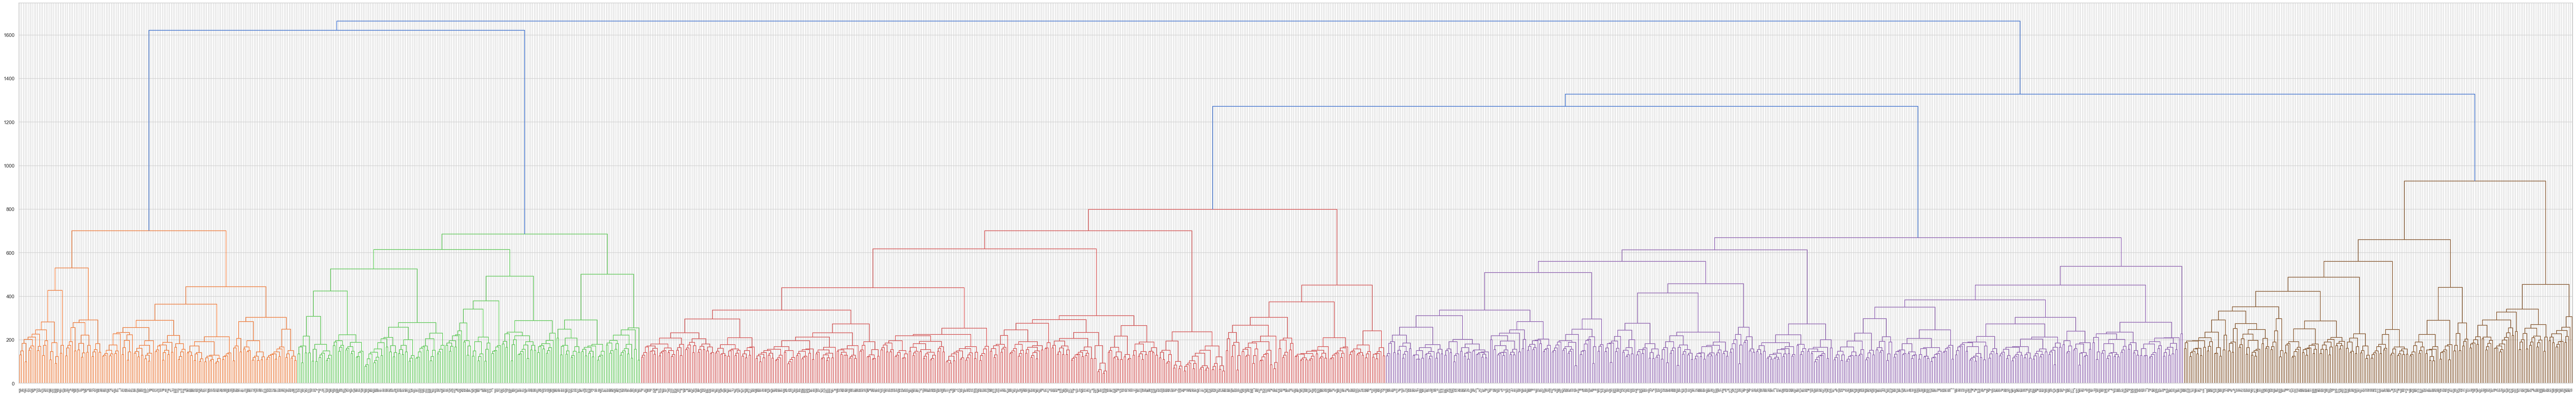

In [17]:
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(data_norm, 'ward')

plt.figure(figsize=(100, 15))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.show()

In [18]:
from sklearn.cluster import AgglomerativeClustering
clusters = AgglomerativeClustering(n_clusters=93, affinity='euclidean', linkage='ward')
clusters.fit_predict(data_norm)

/Users/yunonapospelova/miniconda3/envs/ds/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


array([19, 11, 20, ..., 28, 40,  7])

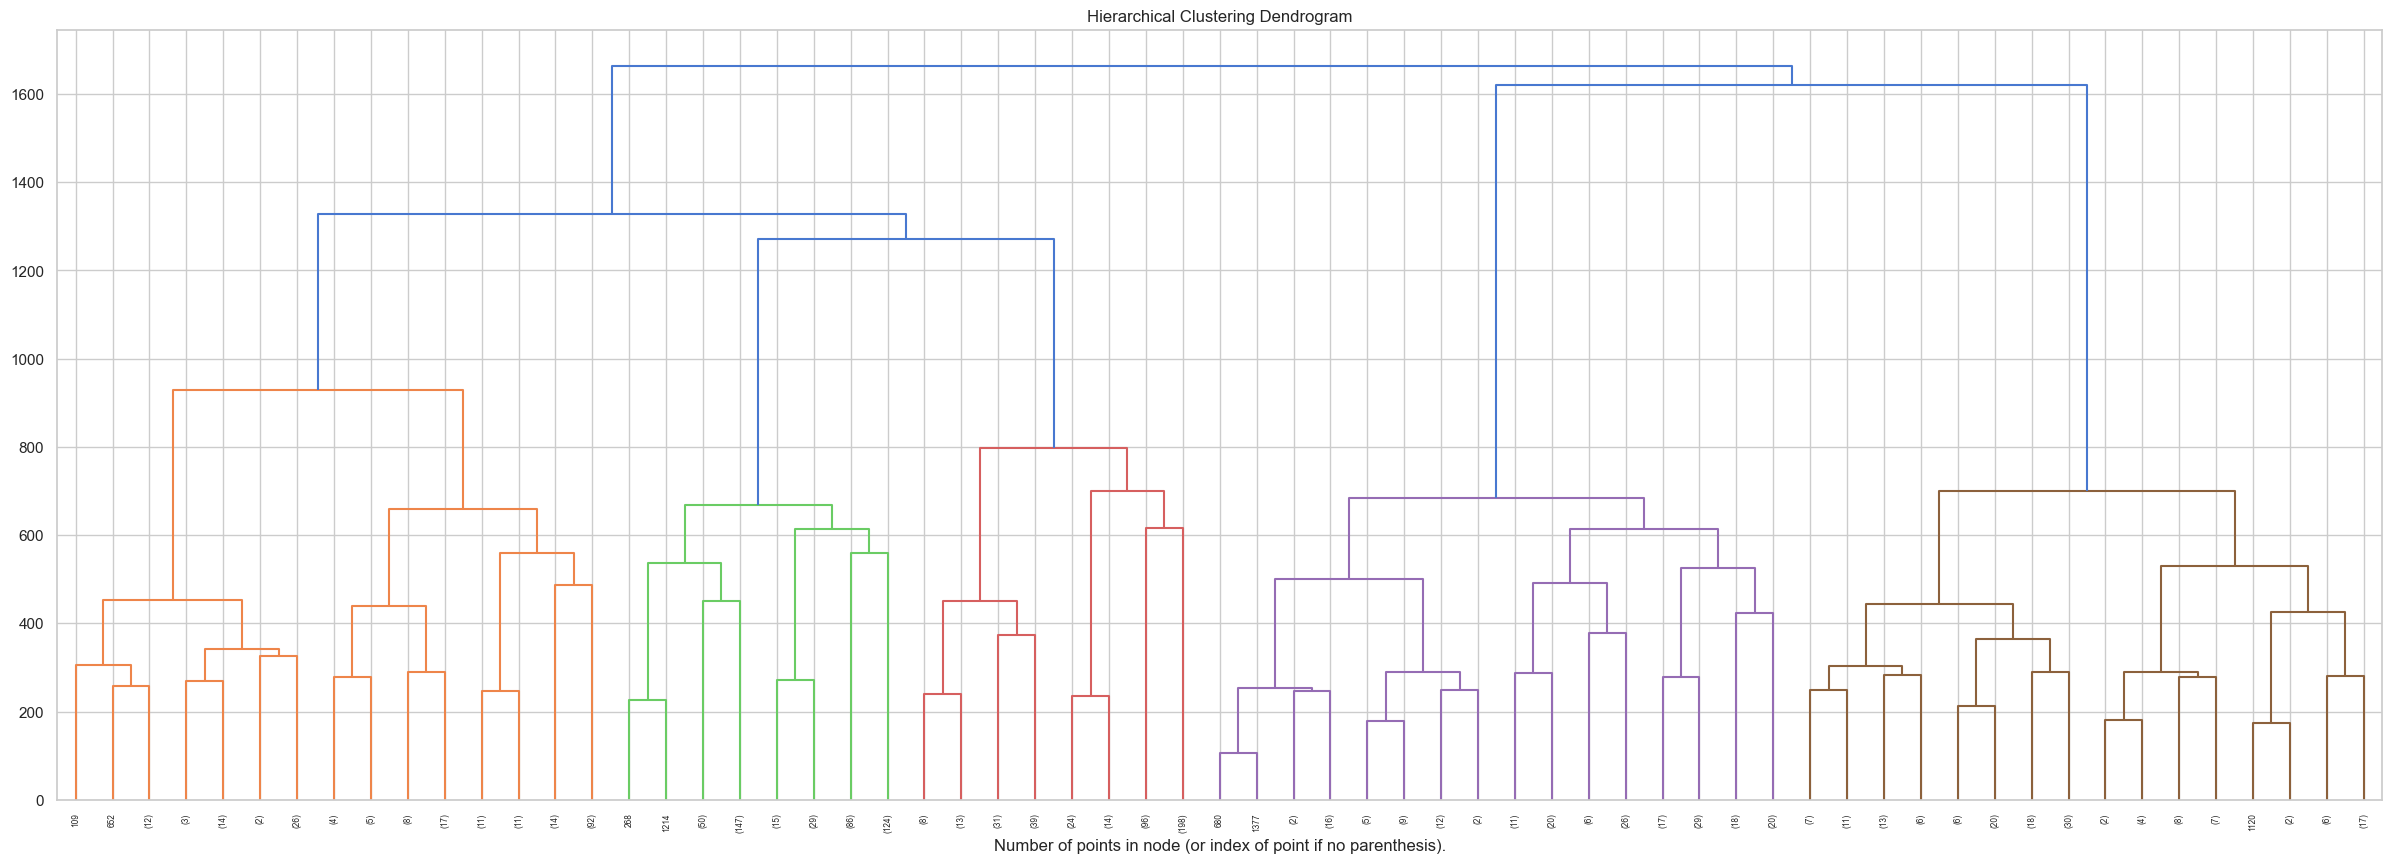

In [19]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(data_norm)
plt.figure(figsize=(30, 10))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top 5 levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [23]:
clusters.labels_

array([19, 11, 20, ..., 28, 40,  7])

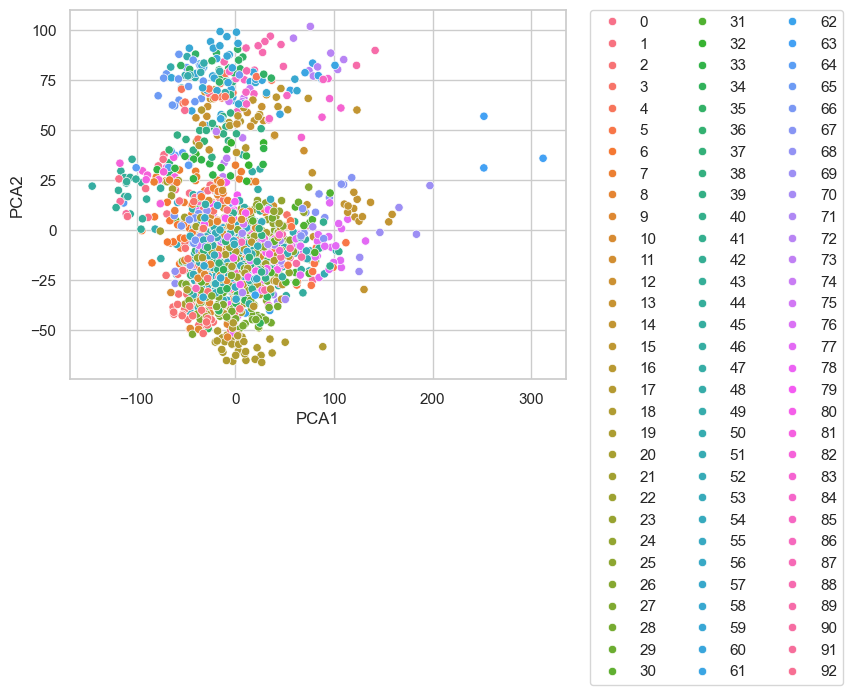

In [27]:
pca_df["HC_labels"] = clusters.labels_
pca_df['HC_labels'] = pca_df.HC_labels.astype('category')
sns.set(style="whitegrid", palette="muted")
#sns.set_theme(style="whitegrid")
ax = sns.scatterplot(x="PCA1", y="PCA2", hue="HC_labels",  data=pca_df)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=4)
#plt.savefig("GSE122505_Leukemia_HC.pdf", dpi = 300)
#plt.savefig("GSE122505_Leukemia_HC.png")
#pca_df.to_csv("GSE122505_Leukemia_HC.csv")

/Users/yunonapospelova/miniconda3/envs/ds/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


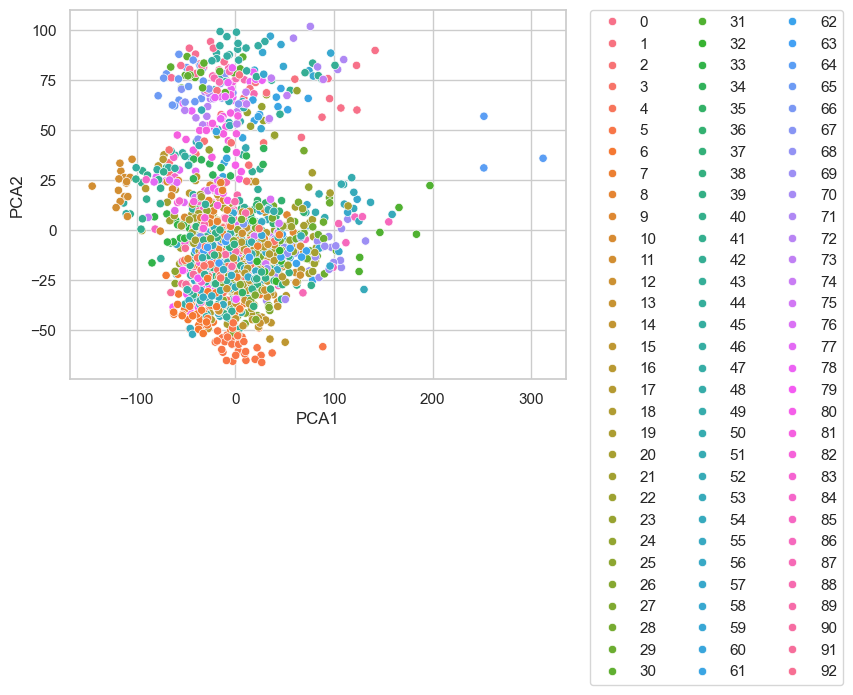

In [26]:
#compute PCA
pca = PCA(n_components=50)
X = pca.fit(data_norm).transform(data_norm)

#conduct hierarchical clustering
cluster = AgglomerativeClustering(n_clusters=93, affinity='euclidean', linkage='ward')
cluster.fit_predict(X)

#plot the labels
pca_df["HC_PCA_labels"] = cluster.labels_
pca_df['HC_PCA_labels'] = pca_df.HC_PCA_labels.astype('category')
sns.set(style="whitegrid", palette="muted")
ax = sns.scatterplot(x="PCA1", y="PCA2", hue="HC_PCA_labels",  data=pca_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=4)

#save it
#plt.savefig("..._HC_PCA.pdf", dpi = 300)
#plt.savefig("..._HC_PCA.png")
#pca_df.to_csv("..._HC_PCA.csv")


## Clustermap (heatmap)

As last step about hierarchical clustering we will plot a heatmap similar to figure 2. Many times, in scientific articles there are shown heatmap with patients on one axis and a selection of gene on the other axis. Here instead of gene expression we are plotting on the x axis PCA components (20 in this case).


/Users/yunonapospelova/miniconda3/envs/ds/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/yunonapospelova/miniconda3/envs/ds/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


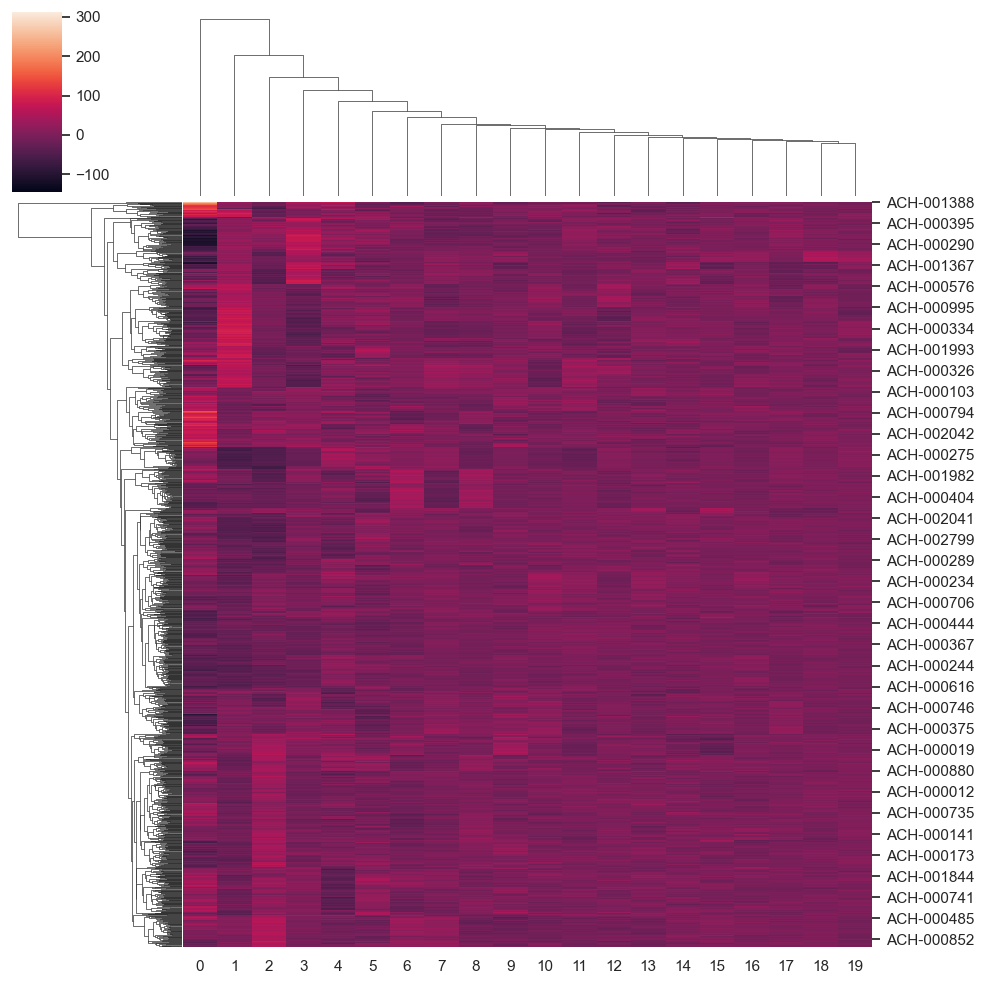

In [31]:
import seaborn as sns; sns.set_theme(color_codes=True)
pca = PCA(n_components=20)
Y = pca.fit(data_norm).transform(data_norm)
Y = pd.DataFrame(Y)
Y.index = data_norm.index
g = sns.clustermap(Y)

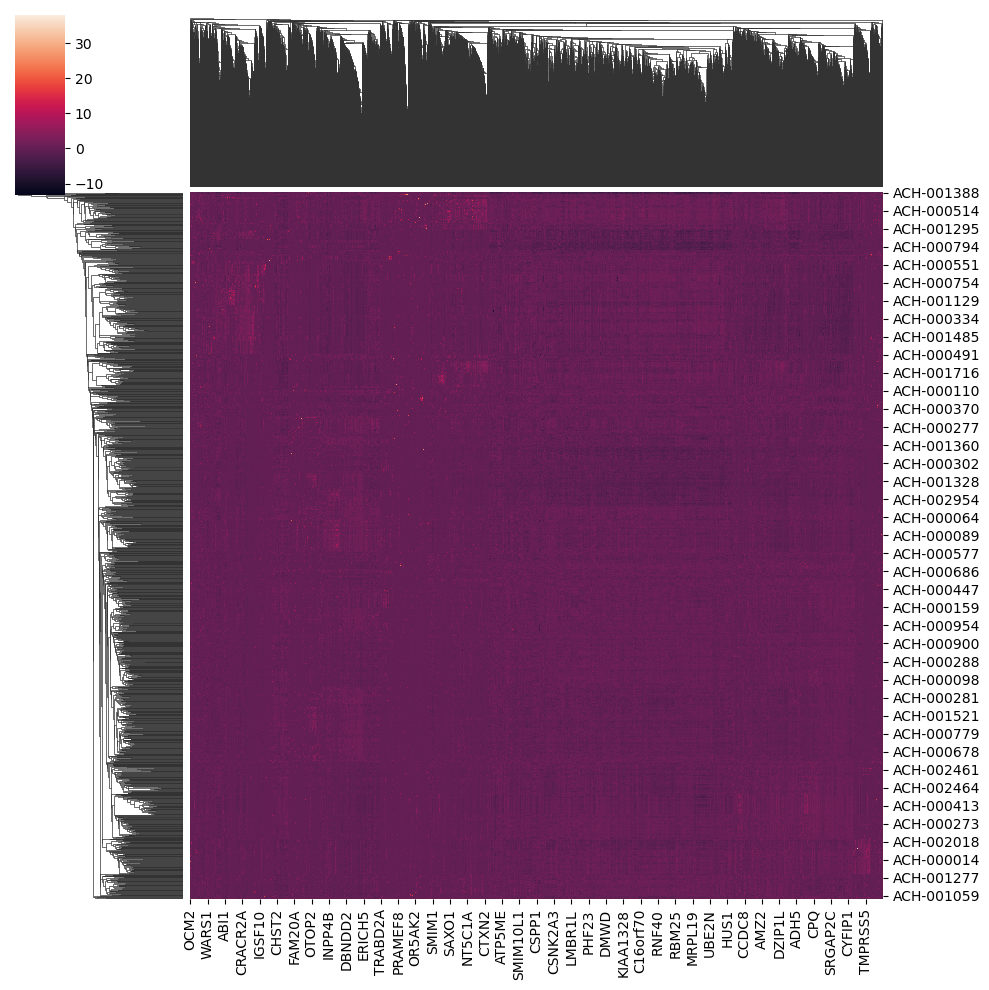

In [10]:
# pip install fastcluster
g = sns.clustermap(data_norm)

## Conducting the same but on ERN genes

PCA

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
X = pca.fit(ERN_data_norm).transform(ERN_data_norm)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(disease)

y_lan = le.transform(disease)
pca_df = pd.DataFrame()
pca_df.index = ERN_data_norm.index
pca_df["PCA1"] = X[:, 0]
pca_df["PCA2"] = X[:, 1]
pca_df["Disease"] = disease
pca_df["label"] = y_lan

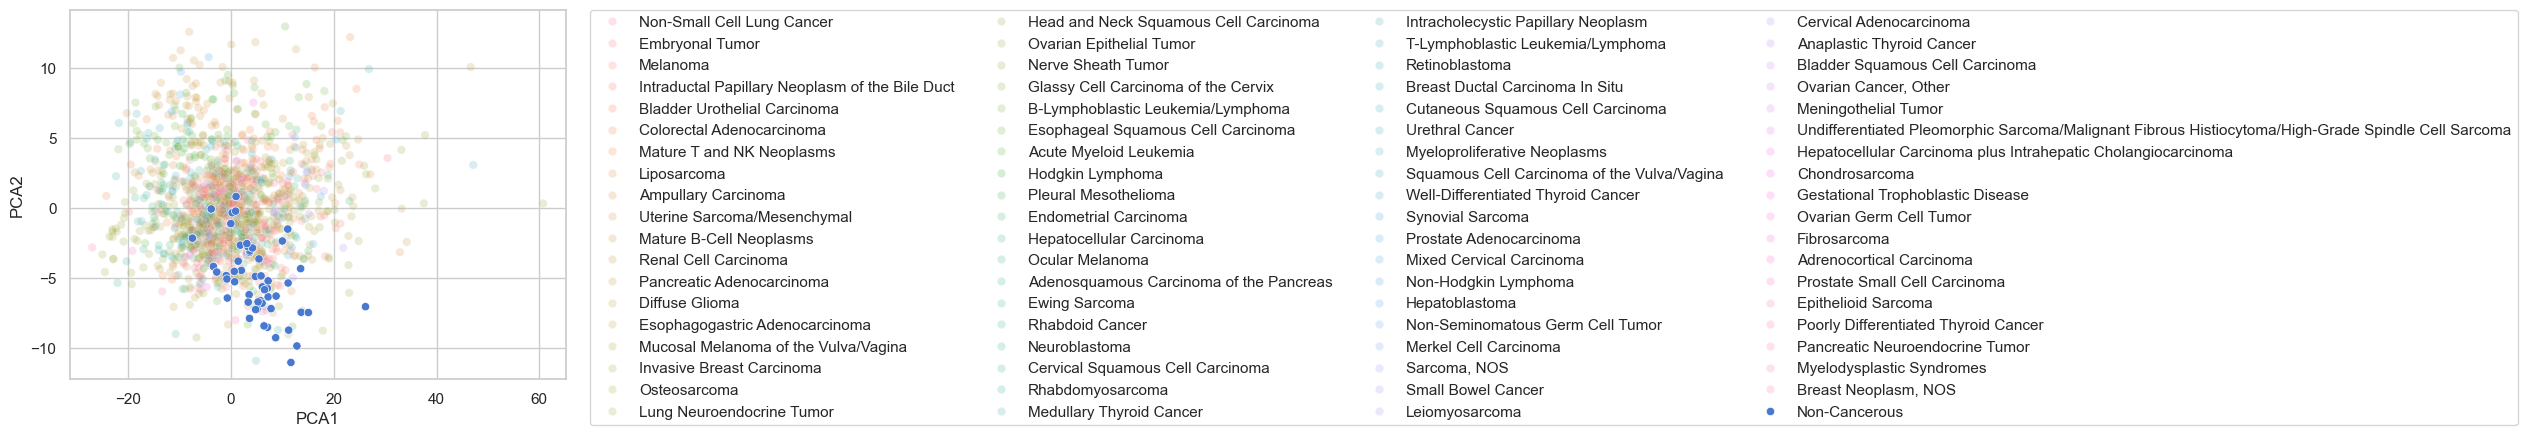

In [20]:
sns.set(style="whitegrid", palette="muted")

# Filter the DataFrame for "Non-cancerous" and other diseases
non_cancerous = pca_df[pca_df['Disease'] == 'Non-Cancerous']
other_diseases = pca_df[pca_df['Disease'] != 'Non-Cancerous']

# First plot the other diseases with higher transparency
ax = sns.scatterplot(x="PCA1", y="PCA2", hue="Disease", data=other_diseases, alpha=0.2)

# Overlay the "Non-cancerous" points with less transparency
sns.scatterplot(x="PCA1", y="PCA2", hue="Disease", data=non_cancerous, ax=ax, alpha=1.0)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=4)

plt.show()

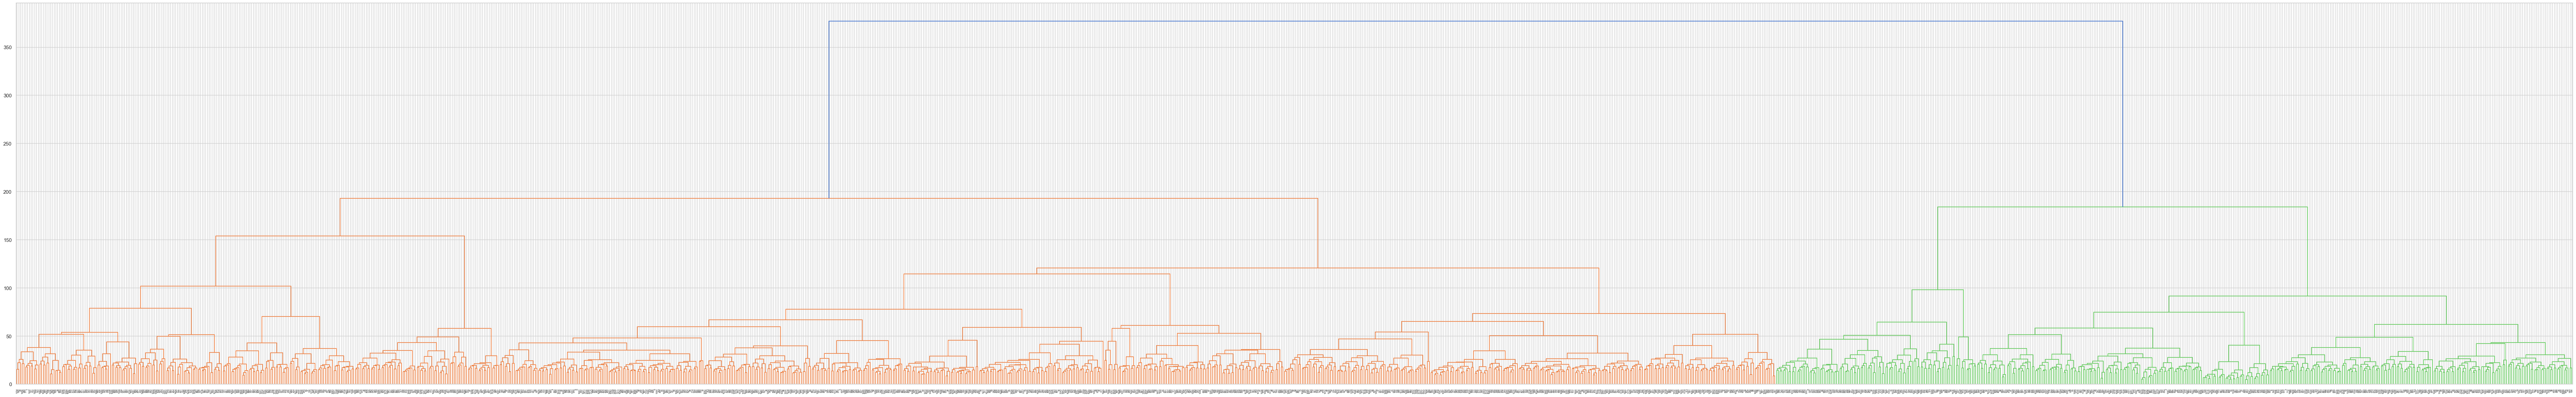

In [21]:
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(ERN_data_norm, 'ward')

plt.figure(figsize=(100, 15))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.show()

In [22]:
from sklearn.cluster import AgglomerativeClustering
clusters = AgglomerativeClustering(n_clusters=93, affinity='euclidean', linkage='ward')
clusters.fit_predict(ERN_data_norm)

/Users/yunonapospelova/miniconda3/envs/ds/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


array([69, 54, 60, ...,  5,  9, 74])

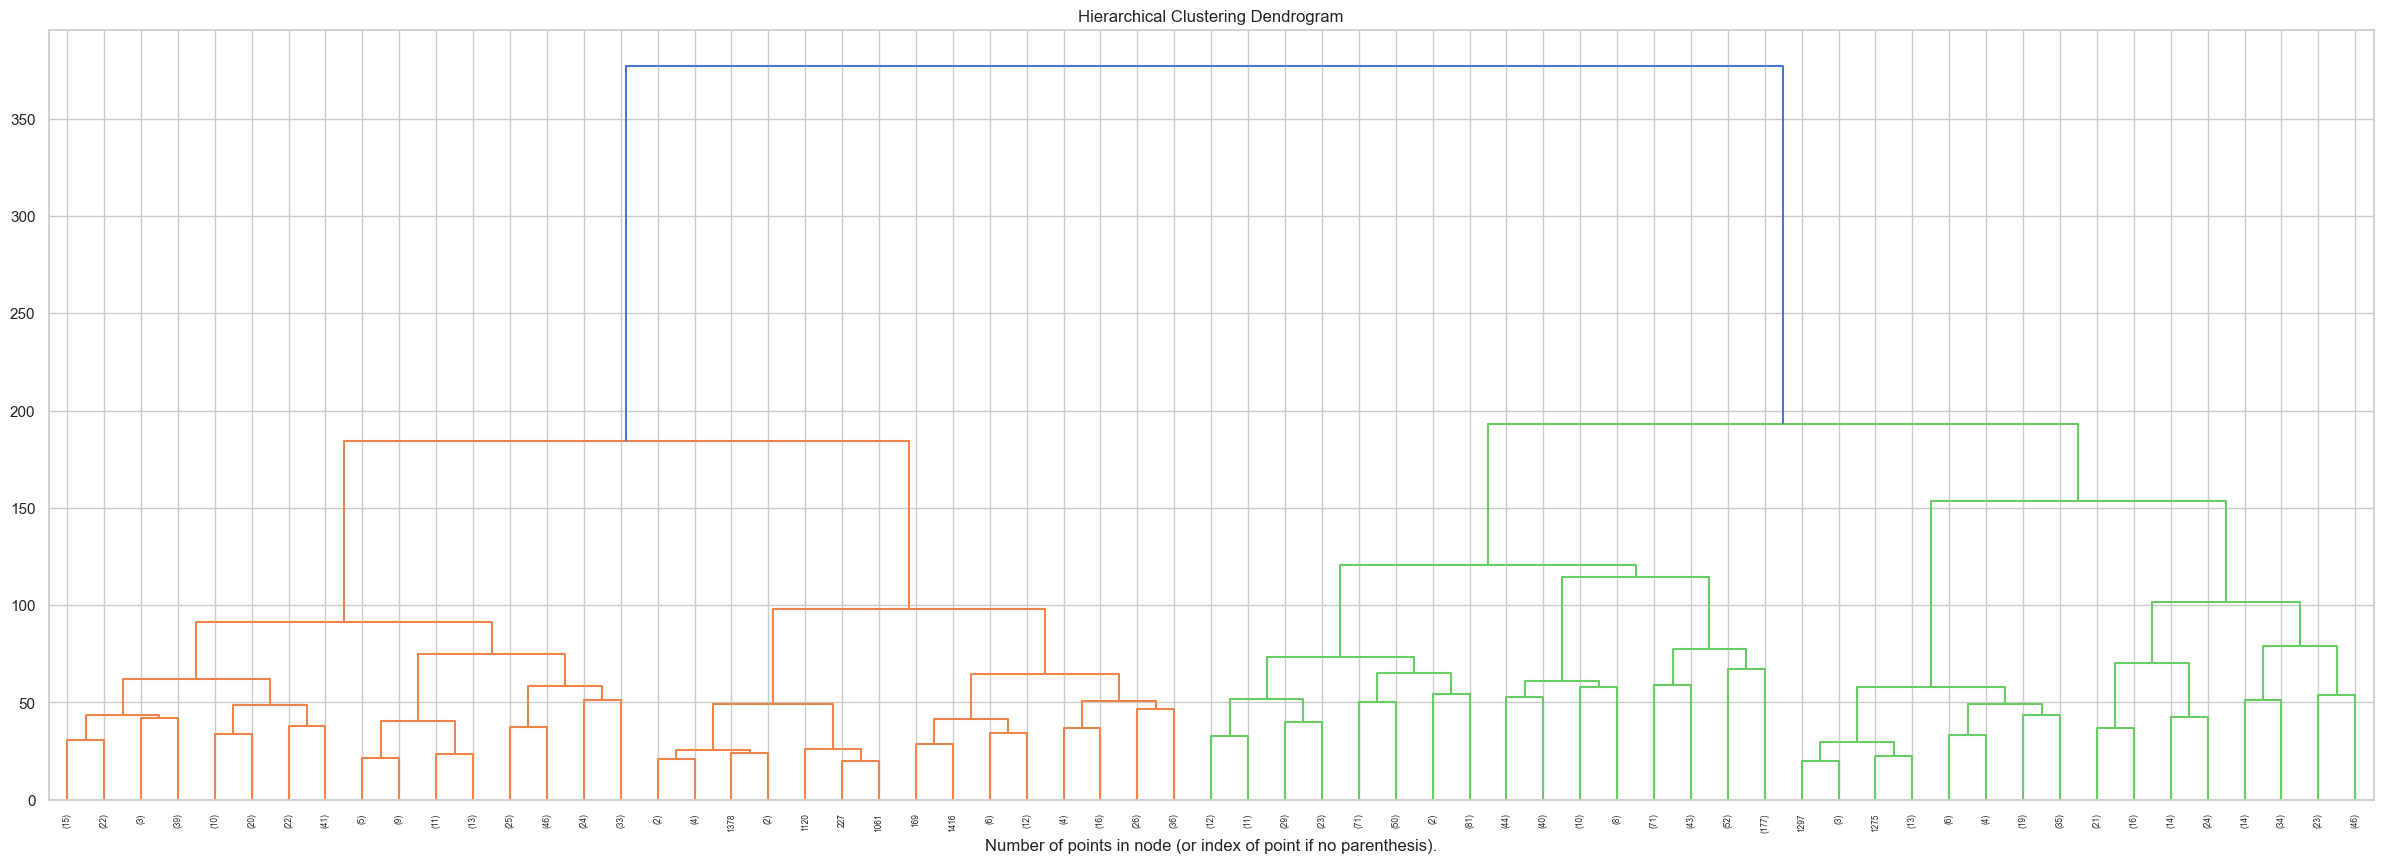

In [23]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # Create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(ERN_data_norm)
plt.figure(figsize=(30, 10))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top 5 levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=5)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [24]:
clusters.labels_

array([69, 54, 60, ...,  5,  9, 74])

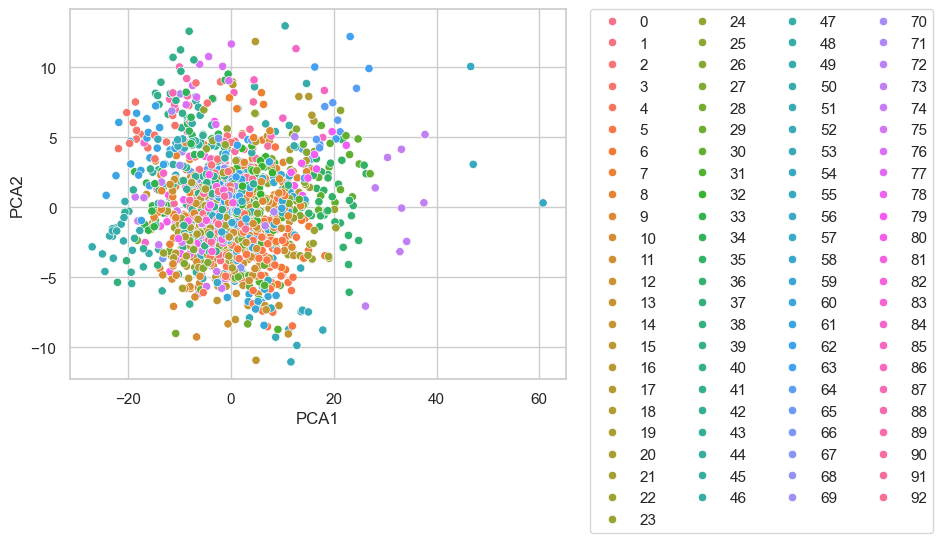

In [25]:
pca_df["HC_labels"] = clusters.labels_
pca_df['HC_labels'] = pca_df.HC_labels.astype('category')
sns.set(style="whitegrid", palette="muted")
#sns.set_theme(style="whitegrid")
ax = sns.scatterplot(x="PCA1", y="PCA2", hue="HC_labels",  data=pca_df)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=4)
#plt.savefig("..._HC.pdf", dpi = 300)
#plt.savefig("..._HC.png")
#pca_df.to_csv("..._HC.csv")

/Users/yunonapospelova/miniconda3/envs/ds/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


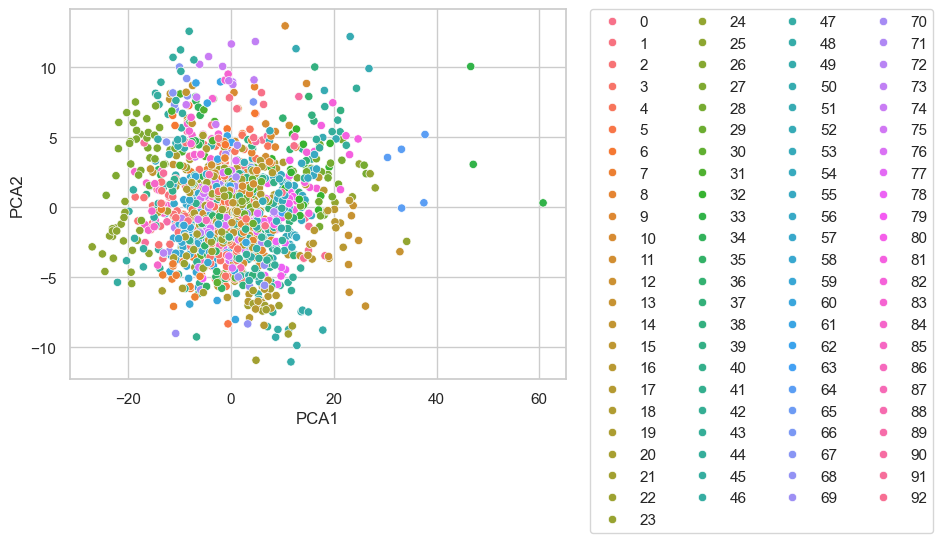

In [26]:
#compute PCA
pca = PCA(n_components=50)
X = pca.fit(ERN_data_norm).transform(ERN_data_norm)

#conduct hierarchical clustering
cluster = AgglomerativeClustering(n_clusters=93, affinity='euclidean', linkage='ward')
cluster.fit_predict(X)

#plot the labels
pca_df["HC_PCA_labels"] = cluster.labels_
pca_df['HC_PCA_labels'] = pca_df.HC_PCA_labels.astype('category')
sns.set(style="whitegrid", palette="muted")
ax = sns.scatterplot(x="PCA1", y="PCA2", hue="HC_PCA_labels",  data=pca_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=4)

#save it
#plt.savefig("..._HC_PCA.pdf", dpi = 300)
#plt.savefig("..._HC_PCA.png")
#pca_df.to_csv("..._HC_PCA.csv")


Cluster Heatmap

As last step about hierarchical clustering we will plot a heatmap similar to figure 2. Many times, in scientific articles there are shown heatmap with patients on one axis and a selection of gene on the other axis. Here instead of gene expression we are plotting on the x axis PCA components (20 in this case).


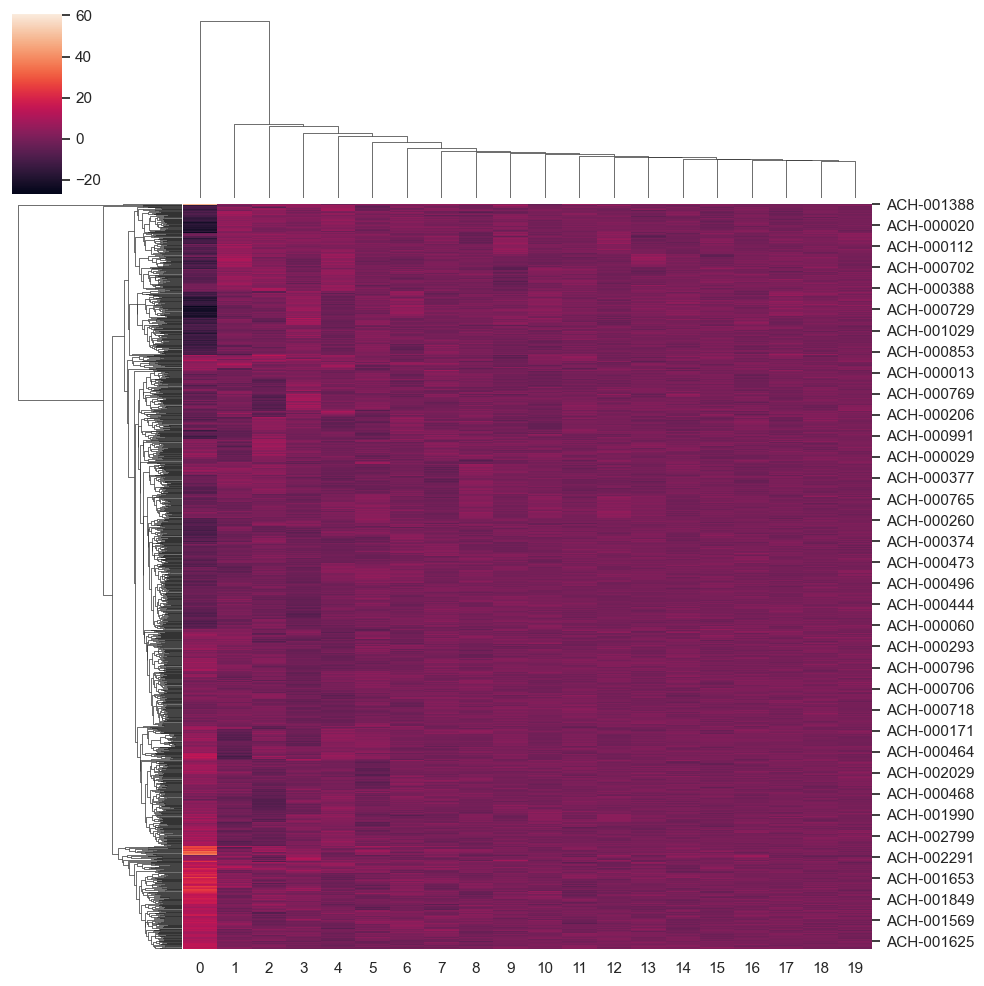

In [27]:
import seaborn as sns; sns.set_theme(color_codes=True)
pca = PCA(n_components=20)
Y = pca.fit(ERN_data_norm).transform(ERN_data_norm)
Y = pd.DataFrame(Y)
Y.index = data_norm.index
g = sns.clustermap(Y)

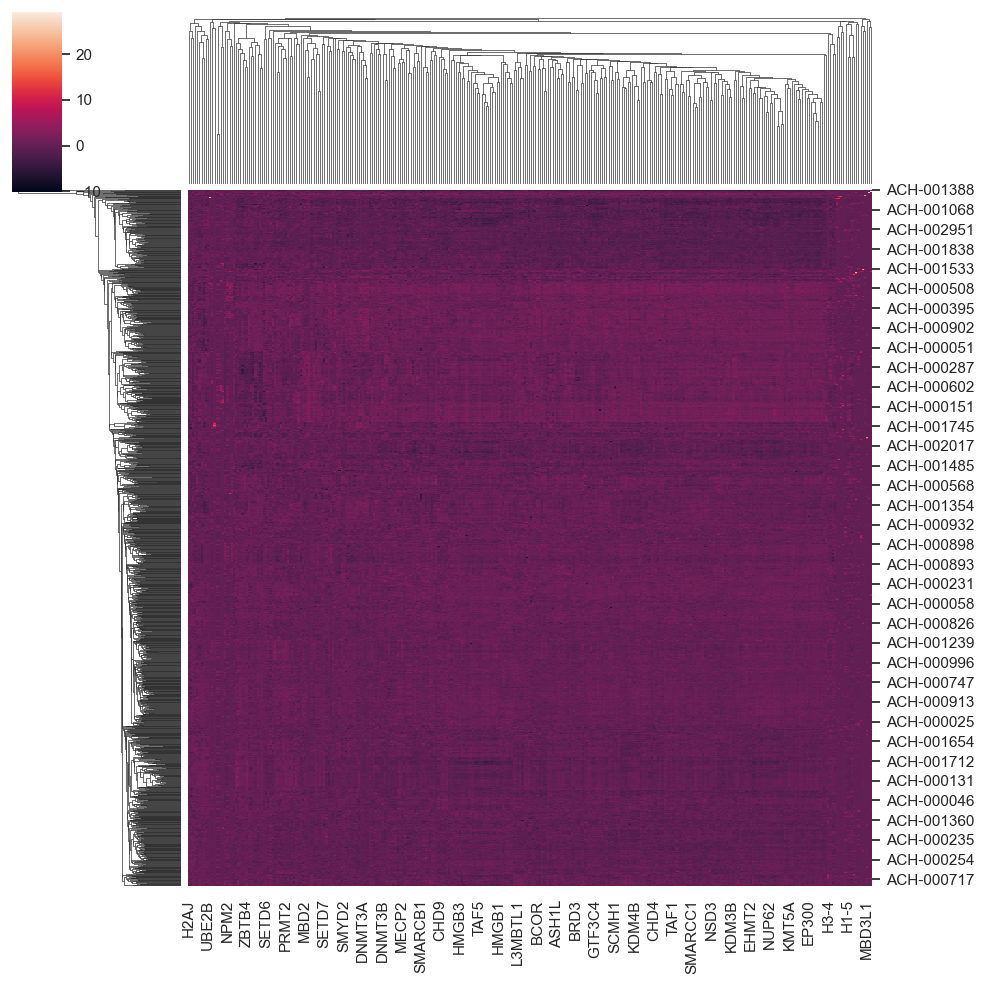

In [28]:
# pip install fastcluster
g = sns.clustermap(ERN_data_norm)